## Notebook Author: Abhinav Jain

# 1-Part-1: Model Building

## 1.1-Introduction

This part aims to create a machine learning solution for predicting intonation from the short audio clips in the MLEnd Spoken Numerals dataset. 

This solution explores various spectral and rhythmic features of the audio clips to prepare the training and validation data. Multiple classification models such as Logistic Regression, K-Nearest Neighbours(KNN), Support Vector Machinces (SVM) and Neural Networks are trained and evaluated.


Following sections describe various steps taken to build the solution such as dataset inspection and preprocessing, model choices, training and validation and models' performance evaluation. 

## 1.2-Dataset

### 1.2.1-Dataset Loading

Dataset was downloaded from the QMUL website to google drive and unzipped. Following code cell mounts the google drive to the notebook and also performs required imports for the solution.

QMUL link for dataset:
https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST0

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob
import urllib.request
import zipfile
import IPython.display as ipd
from tqdm import tqdm
import librosa
import torch
drive.mount('/content/drive')
import warnings
import keras
import librosa.display
import sklearn
from datetime import datetime
from datetime import  date
import time
import matplotlib

Mounted at /content/drive


Commented cells for data downloading and unzipping

Following cells were used for first time downloading and unzipping the data in Drive.

In [ ]:
# def download_url(url, save_path):
#     with urllib.request.urlopen(url) as dl_file:
#         with open(save_path, 'wb') as out_file:
#             out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
# url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
# save_path = '/content/drive/MyDrive/ML Mini Project Data/MLEnd/training.zip'
# download_url(url, save_path)

##### Finally, let's unzip the training file.

In [ ]:
# directory_to_extract_to = '/content/drive/MyDrive/ML Mini Project Data/MLEnd/training/'
# with zipfile.ZipFile(save_path, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

#### Verify if drive mounted and contains our dataset.

In [ ]:
path = '/content/drive/MyDrive/ML Mini Project Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv',
 'trainingMLEnd_intonation_500.csv',
 'training.zip',
 'training']

### 1.2.2-Dataset Inspection

Check the number of audio files in the dataset.

In [ ]:
files = glob.glob('/content/drive/MyDrive/ML Mini Project Data/MLEnd/training/Training/*.wav')
print("Number of audio files found:",len(files))

Number of audio files found: 20000


Listening to some random files from the dataset.

Observations: 
1. Qaulitatively speaking, some audios for same intonation sound very different or do not sound like the tagged intonation. It could either be due to the difference in speaker's way of speaking (different speaking length) or an error in the mapping in CSV file. For example, files 16389 & 8869 have Excited intonation in CSV, but they don't sound like excited.

2. Some files have a very noisy background which could make the learning harder for model.



In [ ]:
audio_test = [15101,8869,16389]
intonation = ["Question","Excited","Excited"]
i = 0
for n in audio_test:
  print("\nFile #", n, ", Intonation:",intonation[i])
  display(ipd.Audio(files[n]))
  i+=1


File # 15101 , Intonation: Question



File # 8869 , Intonation: Excited



File # 16389 , Intonation: Excited


Loading the CSV file from local environment, as the CSV file was adapted to replace text lables with numbers. CSV file has following mapping:
Question: 1

Excited: 2

Neutral: 3

Bored: 4

The digit labels were transformed (all numbers beyond 20 were mapped with 21,22 and so on) , although not being used in this solution.

The CSV file has 20000 rows and 4 columns.

In [ ]:
labels = pd.read_csv('/content/trainingMLEnd_all_num label.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,1
1,0000001.wav,2,S88,2
2,0000002.wav,25,S5,3
3,0000003.wav,2,S85,4
4,0000004.wav,4,S30,2
...,...,...,...,...
19995,0019995.wav,27,S163,2
19996,0019996.wav,10,S99,1
19997,0019997.wav,27,S46,1
19998,0019998.wav,19,S13,3


Checking how many records are present per intonation.

In [ ]:
labels.intonation.value_counts()

4    5000
3    5000
2    5000
1    5000
Name: intonation, dtype: int64

Loading 3 more CSV files, containing subsets of the full-length CSV. These 3 CSV files contain 500, 1000 and 2000 records per intonation for observing the model training with smaller sets.

In [ ]:
labels_intonation_500 = pd.read_csv('/content/trainingMLEnd_intonation_500.csv')
labels_intonation_1000 = pd.read_csv('/content/trainingMLEnd_intonation_1000.csv')
labels_intonation_2000 = pd.read_csv('/content/trainingMLEnd_intonation_2000.csv')

In [ ]:
print(labels_intonation_500.intonation.value_counts())
print(labels_intonation_1000.intonation.value_counts())
print(labels_intonation_2000.intonation.value_counts())

4    500
3    500
2    500
1    500
Name: intonation, dtype: int64
3    1000
1    1000
4    1000
2    1000
Name: intonation, dtype: int64
3    2000
2    2000
1    2000
4    2000
Name: intonation, dtype: int64


Plotting an audio signal to visualize it.

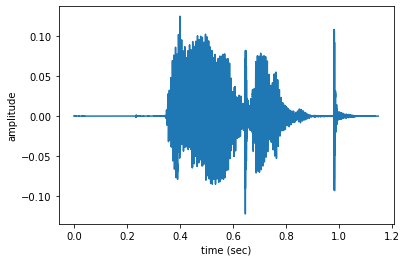

In [ ]:
n=10133
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

### 1.2.3-Dataset Preprocessing

Checking number of samples witnin the single audio file for some randomly selected files.

In [ ]:
fs=None
for _ in range(5):
  x, fs = librosa.load(files[np.random.randint(20000)],sr=fs)
  print("The selected file has",x.shape[0],"samples")

The selected file has 29952 samples
The selected file has 21504 samples
The selected file has 37376 samples
The selected file has 22784 samples
The selected file has 34560 samples


Since each short audio has many thousands of samples, it would be computationally unattractive to use so many samples as predicotrs with thousands of files.

Some features can be extracted from the raw data to represent the audio clip. 
 

References for spectral and rhythmic features:

https://librosa.org/doc/latest/feature.html

https://librosa.org/doc/latest/generated/librosa.display.specshow.html#librosa.display.specshow

https://en.wikipedia.org/wiki/Spectrogram

Spectral features are extracted from the spectrogram. Spectrogram represents a picture of the sound, more formally, the spectrum of frequencies. Visualizing the spectrogram and some of the spectral features:

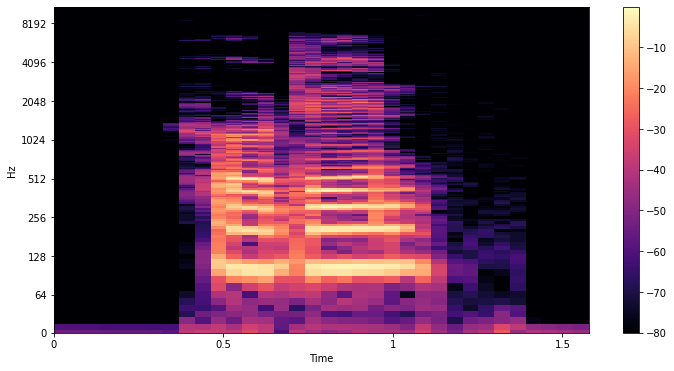

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=1024)),
                            ref=np.max)
plt.figure(figsize=(12,6))
librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=1024,
                         x_axis='time')
plt.colorbar()

Visualizing the feature Spectral centroid:

(https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid)

[Text(0.5, 1.0, 'log Power spectrogram')]

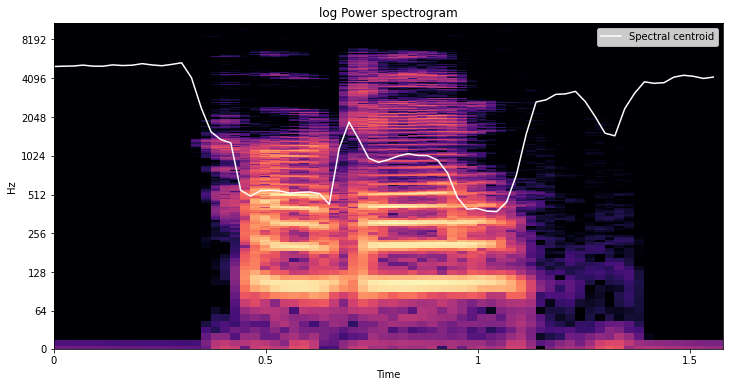

In [ ]:
cent = librosa.feature.spectral_centroid(y=x, sr=fs)

S, phase = librosa.magphase(librosa.stft(y=x))
librosa.feature.spectral_centroid(S=S)

freqs, times, D = librosa.reassigned_spectrogram(x, fill_nan=True)
librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)
times = librosa.times_like(cent)
fig, ax = plt.subplots(figsize=(12,6))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

Visualizing the feature Spectral roll off:

(https://librosa.org/doc/latest/generated/librosa.feature.spectral_rolloff.html)

[Text(0.5, 1.0, 'log Power spectrogram')]

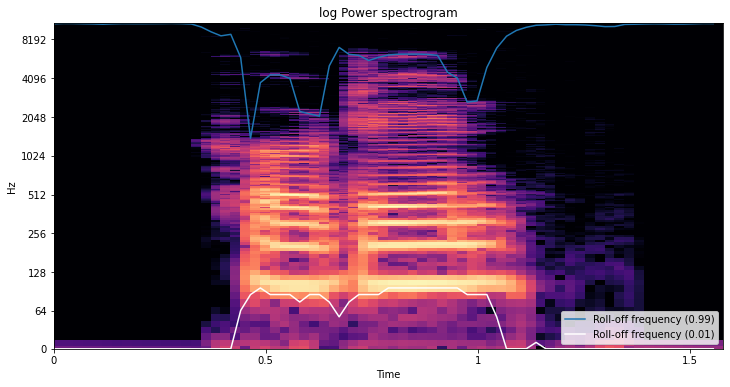

In [ ]:
rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs, roll_percent=0.99)
rolloff_min = librosa.feature.spectral_rolloff(y=x, sr=fs, roll_percent=0.01)
S, phase = librosa.magphase(librosa.stft(x))
fig, ax = plt.subplots(figsize=(12,6))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w',
        label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log Power spectrogram')

In [ ]:
# Function for calculating the pitch (from starter kit)
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
# Normalization function for features
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Function getXy for extracting features.
Following is the list of all features:

1. Power
2. Pitch mean
3. Pitch standard deviation
4. Fraction of voiced region
5. Spectral Centroid 
6. Spectral Bandwidth
7. Spectral RollOff  
8. Zero Crossing Rate  
9. Chroma STFT
10. RMS
11. MFCC  
12. Tonnetz  
13. Spectral Contrast         
14. Spectral flatness  
15. Chroma CENS
16. Chroma CQT
17. MelSpectrogram
18. Tempogram

These features were added progressively in the batches in each iteration as the models built with less features did not show very good results and adding features kept improving the results.

All 18 features together result in 70 predictors.

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  
  X,y =[],[]
  i=0
  print("Loop started...",datetime.now().strftime("%H:%M:%S"))
  for file in files: 
    i+=1
    if i%1000 == 0:
      print("Processing file no:",i,'... at...',datetime.now().strftime("%H:%M:%S"))
    fileID = file.split('/')[-1]
    try:
      xi = []
      yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))

      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      xi.append(power)
      xi.append(pitch_mean)
      xi.append(pitch_std)
      xi.append(voiced_fr)

      # Spectral Centroid
      xi.append(np.mean(normalize(librosa.feature.spectral_centroid(x, sr=fs)[0])))  
      # Spectral Bandwidth
      xi.append(np.mean(normalize(librosa.feature.spectral_bandwidth(x, sr=fs)[0])))
      # Spectral RollOff
      xi.append(np.mean(normalize(librosa.feature.spectral_rolloff(x, sr=fs)[0])))  
      # Zero Crossing Rate  
      xi.append(np.mean(librosa.feature.zero_crossing_rate(x)))
      # Chroma STFT
      xi.append(np.mean(librosa.feature.chroma_stft(x, sr=fs)))
      # RMS
      xi.append(np.mean(librosa.feature.rms(x)))
      # MFCC
      for j in [np.mean(i) for i in normalize(librosa.feature.mfcc(x, sr=fs))]:
        xi.append(j)     
      # Tonnetz
      for j in [np.mean(i) for i in normalize(librosa.feature.tonnetz(y=librosa.effects.harmonic(x), sr=fs))]:
        xi.append(j)   
      # Spectral Contrast  
      for j in [np.mean(i) for i in normalize(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(x)), sr=fs))]:
        xi.append(j)        
      # Spectral flatness
      xi.append(np.mean(librosa.feature.spectral_flatness(x)))   
      # Chroma CENS
      for j in [np.mean(i) for i in normalize(librosa.feature.chroma_cens(y=x, sr=fs))]:
        xi.append(j)
      # Chroma CQT
      for j in [np.mean(i) for i in normalize(librosa.feature.chroma_cqt(y=x, sr=fs))]:
        xi.append(j)
      # MelSpectrogram
      xi.append(np.mean([np.mean(i) for i in normalize(librosa.feature.melspectrogram(y=x, sr=fs))]))
      # Tempogram
      xi.append(np.mean([np.mean(i) for i in normalize(
                              librosa.feature.tempogram(
                              onset_envelope=librosa.onset.onset_strength(y=x, 
                              sr=fs, hop_length=512),sr=fs,hop_length=512))]))
      X.append(xi)
      y.append(yi) 
    except:     
      continue  
  print('Finished at',datetime.now().strftime("%H:%M:%S"))     
  return np.array(X),np.array(y)

Applying the function for getting X and y on all files. 

Since the features were added progressively and finally the 14 new features were added after many iterations in a separate notebook, it is not feasible to run the function here with all files and all features. For completeness, showing the output cell for 100 files.

In [ ]:
with warnings.catch_warnings():  
    warnings.simplefilter("ignore")  # Prevent warnings from printing in ouutput
    X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

Loop started... 05:48:17
Processing file no: 10 ... at... 05:48:26
Processing file no: 20 ... at... 05:48:36
Processing file no: 30 ... at... 05:48:50
Processing file no: 40 ... at... 05:49:06
Processing file no: 50 ... at... 05:49:23
Processing file no: 60 ... at... 05:49:42
Processing file no: 70 ... at... 05:49:59
Processing file no: 80 ... at... 05:50:13
Processing file no: 90 ... at... 05:50:28
Processing file no: 100 ... at... 05:50:44
Finished at 05:50:45


Showing the shape of X and y to demonstrate the working of the function and yielding 70 predictors.

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (100, 70)
The shape of y is (100,)
The labels vector is [4 1 2 2 1 2 3 4 3 3 3 4 4 1 3 4 3 3 1 2 3 2 4 2 4 3 4 4 4 2 1 2 3 3 3 3 3
 1 1 4 1 4 4 1 3 4 2 4 4 1 1 4 4 1 2 3 4 3 3 3 2 4 2 2 1 2 1 4 1 3 4 4 3 4
 1 3 2 1 2 1 3 2 3 2 3 3 2 2 4 4 1 1 1 4 3 4 1 1 4 4]


Above values in X and y are only for 100 files for which the function was run for demo. Going further, X and y will be loaded from the text files which have been prepared by downloading and collating the output of multiple iterations of feature extraction function (getXy).

## 1.3-Models
Following classification models were included in the experiments before choosing the final model post evaluation:


1. SVM with random/default parameters (C=1).
2. SVM with normalized values and tuned parameters using grid search. 
3. Logistic Regression
4. KNN (K=3)
5. Neural network (5 layers with node count as 512,256,128,64,4 respectively).

Although many sets of experiments were run, only a subset of experiments specified below will be shown here to describe the journey to the final model.

1. 2000 files, 500 of each intonation, with first 11 features or 30 predictors.
2. 8000 files, 2000 of each intonation, with first 11 features or 30 predictors.
3. 20000 files, 5000 of each intonation, with first 11 features or 30 predictors.
4. 20000 files, 5000 of each intonation, with first 14 features or 44 predictors.
5. 20000 files, 5000 of each intonation, with all 18 features or 70 predictors.

Please refer to the list of features in the previous section.

## 1.4-Training, Validation and Evaluation

### 1.4.1- Experiment 1, 2000 files, 11 features

Loading already extracted features from saved file, 11 features/30 predictors

In [ ]:
# Loading features from saved file, 11 features/30 predictors
X = np.loadtxt("/content/X_2000_30.txt")
y = np.loadtxt("/content/Y_2000_30.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (2000, 30)
The shape of y is (2000,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1400, 30), (600, 30), (1400,), (600,))

Creating lists for saving experiment summary for each experiment. These will be used at the end of all experiments to plot the summary.

In [ ]:
exp_group = ['E1/2K/11','E2/8K/11','E3/20K/11', 'E4/20K/14','E5/20K/18']
svm0_val_acc = []
svm_val_acc = []
lr_val_acc = []
knn_val_acc = []
nn_val_acc = []

Fitting an SVM model, with random parameters and calculating the training and validation accuracy

In [ ]:
model1_svm0  = svm.SVC(C=1)
model1_svm0.fit(X_train,y_train)

yt_p = model1_svm0.predict(X_train)
yv_p = model1_svm0.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)

svm0_val_acc.append(val_acc)

Training Accuracy 0.4514285714285714
Validation  Accuracy 0.43


Performing grid search to find tuned parameters for SVM model.

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.686, total=  23.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.699, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.696, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.693, total=  23.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.706, total=  23.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.600, total=  15.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.610, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Now fitting another SVM with tuned paramters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model1_svm  = svm.SVC(C=10,gamma=0.1)
model1_svm.fit(X_train,y_train)

yt_p = model1_svm.predict(X_train)
yv_p = model1_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
svm_val_acc.append(val_acc)

Training Accuracy 0.9985714285714286
Validation  Accuracy 0.5183333333333333


As seen above, tuned parameters increase the accuracy but it is still not good.

Now, fitting a logistic regression model and printing the training and validation accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(random_state=42, C=1e5, max_iter=2000).fit(X_train, y_train)
yt_p = clf1.predict(X_train)
yv_p = clf1.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
lr_val_acc.append(val_acc)

Training Accuracy 0.5721428571428572
Validation  Accuracy 0.525


Next, KNN model is tried. It was understood with various values of K, that K=3 gives best results for our data for KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh1 = KNeighborsClassifier(n_neighbors=3)
neigh1.fit(X_train, y_train)
yt_p = neigh1.predict(X_train)
yv_p = neigh1.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
knn_val_acc.append(val_acc)

Training Accuracy 0.6821428571428572
Validation  Accuracy 0.45


Next, a neural network is tried. 

After trying several combinations, model architecture with below configuration of layers was found best suited for the dataset - 

Layer1(512) - Layer2(256) - Layer3(128) - Layer4(64)-Layer5(4 output classes)

Activation - Relu, Softmax for output layer

Epochs-20, Batch size-10

In [ ]:
from keras import models as keras_models
from keras import layers

model1_nn = keras_models.Sequential()
model1_nn.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model1_nn.add(layers.Dense(256, activation='relu'))
model1_nn.add(layers.Dense(128, activation='relu'))
model1_nn.add(layers.Dense(64, activation='relu'))
model1_nn.add(layers.Dense(4, activation='softmax'))

model1_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1_nn.fit(X_train,
                      y_train,
                      epochs=20,
                      batch_size=10)

test_loss,test_acc = model1_nn.evaluate(X_val,y_val)
print('test_acc: ',test_acc)
nn_val_acc.append(test_acc)

Epoch 1/20
140/140 [==============================] - 1s 3ms/step - loss: 1.2702 - accuracy: 0.3859
Epoch 2/20
140/140 [==============================] - 0s 3ms/step - loss: 1.0068 - accuracy: 0.5461
Epoch 3/20
140/140 [==============================] - 0s 3ms/step - loss: 1.0018 - accuracy: 0.5481
Epoch 4/20
140/140 [==============================] - 0s 3ms/step - loss: 0.9499 - accuracy: 0.5487
Epoch 5/20
140/140 [==============================] - 0s 3ms/step - loss: 0.8961 - accuracy: 0.6144
Epoch 6/20
140/140 [==============================] - 0s 3ms/step - loss: 0.8681 - accuracy: 0.6080
Epoch 7/20
140/140 [==============================] - 0s 3ms/step - loss: 0.7955 - accuracy: 0.6452
Epoch 8/20
140/140 [==============================] - 0s 3ms/step - loss: 0.7709 - accuracy: 0.6681
Epoch 9/20
140/140 [==============================] - 0s 3ms/step - loss: 0.7733 - accuracy: 0.6668
Epoch 10/20
140/140 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.7192

### 1.4.2- Experiment 2, 8000 files, 11 features

In the experiment 1, it was observed that all the models had validation accuracy between 41-52 % which is not adequate. 

It may have been because of insufficient training data for a complex task of learning about audio data.

Next, these experiments are run with a bigger data size.

Loading already extracted features from saved file, 11 features/30 predictors

In [ ]:
# Loading features from saved file, 11 features/30 predictors
X = np.loadtxt("/content/X_8000_30.txt")
y = np.loadtxt("/content/Y_8000_30.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (8000, 30)
The shape of y is (8000,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5600, 30), (2400, 30), (5600,), (2400,))

Fitting an SVM model, with random parameters and calculating the training and validation accuracy

In [ ]:
model2_svm0  = svm.SVC(C=1)
model2_svm0.fit(X_train,y_train)

yt_p = model2_svm0.predict(X_train)
yv_p = model2_svm0.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

svm0_val_acc.append(val_acc)

Training Accuracy 0.4669642857142857
Validation  Accuracy 0.4508333333333333


Performing grid search to find tuned parameters for SVM model.

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.686, total=  23.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.699, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.696, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.693, total=  23.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.706, total=  23.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.600, total=  15.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.610, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Now fitting SVM with tuned parameters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model2_svm  = svm.SVC(C=10,gamma=0.1)
model2_svm.fit(X_train,y_train)

yt_p = model2_svm.predict(X_train)
yv_p = model2_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
svm_val_acc.append(val_acc)

Training Accuracy 0.9828571428571429
Validation  Accuracy 0.6195833333333334


As seen, above, more training data has slightly increased the accuracy.

Now, fitting a logistic regression model and printing the training and validation accuracy.


In [ ]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(random_state=42, C=1e5, max_iter=2000).fit(X_train, y_train)
yt_p = clf2.predict(X_train)
yv_p = clf2.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
lr_val_acc.append(val_acc)

Training Accuracy 0.5648214285714286
Validation  Accuracy 0.5558333333333333


Next, KNN model is tried. It was understood with various values of K, that K=3 gives best results for our data for KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh2 = KNeighborsClassifier(n_neighbors=3)
neigh2.fit(X_train, y_train)
yt_p = neigh2.predict(X_train)
yv_p = neigh2.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
knn_val_acc.append(val_acc)

Training Accuracy 0.75375
Validation  Accuracy 0.5158333333333334


Next, a neural network is tried.

After trying several combinations, model architecture with below configuration of layers was found best suited for the dataset -

Layer1(512) - Layer2(256) - Layer3(128) - Layer4(64)-Layer5(4 output classes)

Activation - Relu, Softmax for output layer Epochs-20, Batch size-10

In [ ]:
from keras import models as keras_models
from keras import layers

model2_nn = keras_models.Sequential()
model2_nn.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model2_nn.add(layers.Dense(256, activation='relu'))
model2_nn.add(layers.Dense(128, activation='relu'))
model2_nn.add(layers.Dense(64, activation='relu'))
model2_nn.add(layers.Dense(4, activation='softmax'))

model2_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model2_nn.fit(X_train,
                      y_train,
                      epochs=20,
                      batch_size=10)

test_loss,test_acc = model2_nn.evaluate(X_val,y_val)
print('test_acc: ',test_acc)
nn_val_acc.append(test_acc)

Epoch 1/20
560/560 [==============================] - 2s 3ms/step - loss: 1.1486 - accuracy: 0.4558
Epoch 2/20
560/560 [==============================] - 2s 3ms/step - loss: 0.9843 - accuracy: 0.5435
Epoch 3/20
560/560 [==============================] - 2s 3ms/step - loss: 0.9446 - accuracy: 0.5603
Epoch 4/20
560/560 [==============================] - 2s 3ms/step - loss: 0.9179 - accuracy: 0.5829
Epoch 5/20
560/560 [==============================] - 2s 3ms/step - loss: 0.8779 - accuracy: 0.6060
Epoch 6/20
560/560 [==============================] - 2s 3ms/step - loss: 0.8458 - accuracy: 0.6217
Epoch 7/20
560/560 [==============================] - 2s 3ms/step - loss: 0.8158 - accuracy: 0.6429
Epoch 8/20
560/560 [==============================] - 2s 3ms/step - loss: 0.7631 - accuracy: 0.6680
Epoch 9/20
560/560 [==============================] - 2s 3ms/step - loss: 0.7566 - accuracy: 0.6608
Epoch 10/20
560/560 [==============================] - 2s 3ms/step - loss: 0.6770 - accuracy: 0.7082

### 1.4.3- Experiment 3, 20000 files, 11 features

Loading already extracted features from saved file, 11 features/30 predictors

In [ ]:
# Loading features from saved file, 11 features/30 predictors
X = np.loadtxt("/content/X_20000_30.txt")
y = np.loadtxt("/content/Y_20000_30.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (20000, 30)
The shape of y is (20000,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14000, 30), (6000, 30), (14000,), (6000,))

In [ ]:
model3_svm0  = svm.SVC(C=1)
model3_svm0.fit(X_train,y_train)

yt_p = model3_svm0.predict(X_train)
yv_p = model3_svm0.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

svm0_val_acc.append(val_acc)

Training Accuracy 0.46014285714285713
Validation  Accuracy 0.4746666666666667


Performing grid search to find tuned parameters for SVM model.

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.686, total=  23.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.699, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.696, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.693, total=  23.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.706, total=  23.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.600, total=  15.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.610, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Now fitting SVM with tuned parameters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model3_svm  = svm.SVC(C=10,gamma=0.1)
model3_svm.fit(X_train,y_train)

yt_p = model3_svm.predict(X_train)
yv_p = model3_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
svm_val_acc.append(val_acc)

Training Accuracy 0.9650714285714286
Validation  Accuracy 0.7016666666666667


Now, fitting a logistic regression model and printing the training and validation accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression(random_state=42, C=1e5, max_iter=2000).fit(X_train, y_train)
yt_p = clf3.predict(X_train)
yv_p = clf3.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
lr_val_acc.append(val_acc)

Training Accuracy 0.5573571428571429
Validation  Accuracy 0.564


Next, KNN model is tried. It was understood with various values of K, that K=3 gives best results for our data for KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh3.fit(X_train, y_train)
yt_p = neigh3.predict(X_train)
yv_p = neigh3.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
knn_val_acc.append(val_acc)

Training Accuracy 0.8025714285714286
Validation  Accuracy 0.599


Next, a neural network is tried.

After trying several combinations, model architecture with below configuration of layers was found best suited for the dataset -

Layer1(512) - Layer2(256) - Layer3(128) - Layer4(64)-Layer5(4 output classes)

Activation - Relu, Softmax for output layer 

Epochs-20, Batch size-10

In [ ]:
from keras import models as keras_models
from keras import layers

model3_nn = keras_models.Sequential()
model3_nn.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model3_nn.add(layers.Dense(256, activation='relu'))
model3_nn.add(layers.Dense(128, activation='relu'))
model3_nn.add(layers.Dense(64, activation='relu'))
model3_nn.add(layers.Dense(4, activation='softmax'))

model3_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model3_nn.fit(X_train,
                      y_train,
                      epochs=20,
                      batch_size=10)

test_loss,test_acc = model3_nn.evaluate(X_val,y_val)
print('test_acc: ',test_acc)
nn_val_acc.append(test_acc)

Epoch 1/20
1400/1400 [==============================] - 5s 3ms/step - loss: 1.0956 - accuracy: 0.4977
Epoch 2/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.9608 - accuracy: 0.5661
Epoch 3/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.9230 - accuracy: 0.5769
Epoch 4/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8952 - accuracy: 0.5953
Epoch 5/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8399 - accuracy: 0.6261
Epoch 6/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8048 - accuracy: 0.6499
Epoch 7/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.7618 - accuracy: 0.6614
Epoch 8/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.7122 - accuracy: 0.6908
Epoch 9/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6728 - accuracy: 0.7131
Epoch 10/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.629

### 1.4.4- Experiment 4, 20000 files, 14 features

Loading already extracted features from saved file, 14 features/44 predictors

In [ ]:
# Loading features from saved file, 14 features/44 predictors
X = np.loadtxt("/content/X_20000_44.txt")
y = np.loadtxt("/content/Y_20000_30.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (20000, 44)
The shape of y is (20000,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14000, 44), (6000, 44), (14000,), (6000,))

Fitting an SVM model, with random parameters and calculating the training and validation accuracy

In [ ]:
model4_svm0  = svm.SVC(C=1)
model4_svm0.fit(X_train,y_train)

yt_p = model4_svm0.predict(X_train)
yv_p = model4_svm0.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

svm0_val_acc.append(val_acc)


Training Accuracy 0.465
Validation  Accuracy 0.4701666666666667


Performing grid search to find tuned parameters for SVM model.

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.686, total=  23.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.699, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.696, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.693, total=  23.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.706, total=  23.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.600, total=  15.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.610, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Now fitting SVM with tuned parameters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model4_svm  = svm.SVC(C=10,gamma=0.1)
model4_svm.fit(X_train,y_train)

yt_p = model4_svm.predict(X_train)
yv_p = model4_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
svm_val_acc.append(val_acc)

Training Accuracy 1.0
Validation  Accuracy 0.7358333333333333


Now, fitting a logistic regression model and printing the training and validation accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf4 = LogisticRegression(random_state=42, C=1e5, max_iter=2000).fit(X_train, y_train)
yt_p = clf4.predict(X_train)
yv_p = clf4.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
lr_val_acc.append(val_acc)

Training Accuracy 0.5686428571428571
Validation  Accuracy 0.5688333333333333


Next, KNN model is tried. It was understood with various values of K, that K=3 gives best results for our data for KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh4 = KNeighborsClassifier(n_neighbors=3)
neigh4.fit(X_train, y_train)
yt_p = neigh4.predict(X_train)
yv_p = neigh4.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
knn_val_acc.append(val_acc)

Training Accuracy 0.8345
Validation  Accuracy 0.6455


Next, a neural network is tried.

After trying several combinations, model architecture with below configuration of layers was found best suited for the dataset -

Layer1(512) - Layer2(256) - Layer3(128) - Layer4(64)-Layer5(4 output classes)

Activation - Relu, Softmax for output layer 

Epochs-20, Batch size-10

In [ ]:
from keras import models as keras_models
from keras import layers

model4_nn = keras_models.Sequential()
model4_nn.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model4_nn.add(layers.Dense(256, activation='relu'))
model4_nn.add(layers.Dense(128, activation='relu'))
model4_nn.add(layers.Dense(64, activation='relu'))
model4_nn.add(layers.Dense(4, activation='softmax'))

model4_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model4_nn.fit(X_train,
                      y_train,
                      epochs=20,
                      batch_size=10)

test_loss,test_acc = model4_nn.evaluate(X_val,y_val)
print('test_acc: ',test_acc)
nn_val_acc.append(test_acc)

Epoch 1/20
1400/1400 [==============================] - 5s 3ms/step - loss: 1.0826 - accuracy: 0.5015
Epoch 2/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.9218 - accuracy: 0.5759
Epoch 3/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8474 - accuracy: 0.6156
Epoch 4/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8001 - accuracy: 0.6481
Epoch 5/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.7342 - accuracy: 0.6842
Epoch 6/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6768 - accuracy: 0.7190
Epoch 7/20
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6001 - accuracy: 0.7517
Epoch 8/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5540 - accuracy: 0.7697
Epoch 9/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4982 - accuracy: 0.8015
Epoch 10/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.438

### 1.4.5- Experiment 5, 20000 files, 18 features

Loading already extracted features from saved file, 18 features/70 predictors

In [ ]:
# Loading features from saved file, 18 features/70 predictors
X = np.loadtxt("/content/X_20000_70.txt")
y = np.loadtxt("/content/Y_20000_30.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (20000, 70)
The shape of y is (20000,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14000, 70), (6000, 70), (14000,), (6000,))

Fitting an SVM model, with random parameters and calculating the training and validation accuracy

In [ ]:
model5_svm0  = svm.SVC(C=1)
model5_svm0.fit(X_train,y_train)

yt_p = model5_svm0.predict(X_train)
yv_p = model5_svm0.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

svm0_val_acc.append(val_acc)

Performing grid search to find tuned parameters for SVM model.

In [ ]:
param_grid = [{"C":[1,10,100,1000],"gamma" : [0.1,0.01,0.001,0.00001],"kernel":["rbf"]}]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.686, total=  23.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.699, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.1s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.696, total=  23.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.693, total=  23.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.706, total=  23.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.600, total=  15.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.9s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.610, total=  15.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.606, total=  14.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Now fitting SVM with tuned parameters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model5_svm  = svm.SVC(C=10,gamma=0.1)
model5_svm.fit(X_train,y_train)

yt_p = model5_svm.predict(X_train)
yv_p = model5_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
svm_val_acc.append(val_acc)

Training Accuracy 1.0
Validation  Accuracy 0.7678333333333334


Now, fitting a logistic regression model and printing the training and validation accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf5 = LogisticRegression(random_state=42, C=1e5, max_iter=2000).fit(X_train, y_train)
yt_p = clf5.predict(X_train)
yv_p = clf5.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
lr_val_acc.append(val_acc)

Training Accuracy 0.589
Validation  Accuracy 0.591


Next, KNN model is tried. It was understood with various values of K, that K=3 gives best results for our data for KNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh5 = KNeighborsClassifier(n_neighbors=3)
neigh5.fit(X_train, y_train)
yt_p = neigh5.predict(X_train)
yv_p = neigh5.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)
knn_val_acc.append(val_acc)

Training Accuracy 0.8556428571428571
Validation  Accuracy 0.7165


Next, a neural network is tried.
After trying several combinations, model architecture with below configuration of layers was found best suited for the dataset -

Layer1(512) - Layer2(256) - Layer3(128) - Layer4(64)-Layer5(4 output classes)

Activation - Relu, Softmax for output layer 

Epochs-20, Batch size-10

In [ ]:
model5_nn = keras_models.Sequential()
model5_nn.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model5_nn.add(layers.Dense(256, activation='relu'))
model5_nn.add(layers.Dense(128, activation='relu'))
model5_nn.add(layers.Dense(64, activation='relu'))
model5_nn.add(layers.Dense(4, activation='softmax'))

model5_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model5_nn.fit(X_train,
                      y_train,
                      epochs=20,
                      batch_size=10)

test_loss,test_acc = model5_nn.evaluate(X_val,y_val)
print('test_acc: ',test_acc)
nn_val_acc.append(test_acc)

Epoch 1/20
1400/1400 [==============================] - 5s 3ms/step - loss: 1.0582 - accuracy: 0.5168
Epoch 2/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8852 - accuracy: 0.6063
Epoch 3/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.8098 - accuracy: 0.6494
Epoch 4/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.7339 - accuracy: 0.6827
Epoch 5/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6688 - accuracy: 0.7223
Epoch 6/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.6040 - accuracy: 0.7483
Epoch 7/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5376 - accuracy: 0.7758
Epoch 8/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4725 - accuracy: 0.8120
Epoch 9/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.4209 - accuracy: 0.8287
Epoch 10/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.360

### 1.4.6-Evaluation and model selection

Following plot shows the comparison of the validation accuracies of different models captured in 5 experiments above.

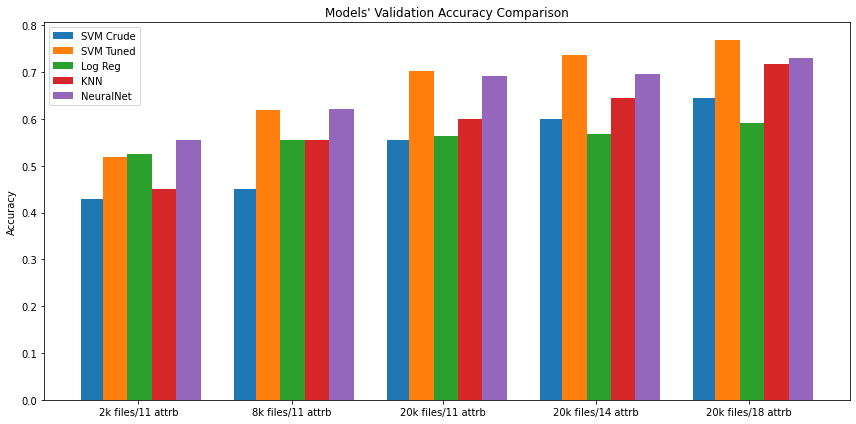

In [ ]:
labels = ["2k files/11 attrb","8k files/11 attrb","20k files/11 attrb",
            "20k files/14 attrb", "20k files/18 attrb"]

# Accuracies captured during experiments
svm0_acc = svm0_val_acc
svm_acc = svm_val_acc
lr_acc = lr_val_acc
knn_acc = knn_val_acc
nn_acc = nn_val_acc

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/9, svm0_acc, width, label='SVM Crude')
rects2 = ax.bar(x + (4*width)/5, svm_acc, width, label='SVM Tuned')
rects3 = ax.bar(x + (9*width)/5, lr_acc, width, label='Log Reg')
rects4 = ax.bar(x + (14*width)/5, knn_acc, width, label='KNN')
rects5 = ax.bar(x + (19*width)/5, nn_acc, width, label='NeuralNet')

# Add text for labels, title and x-axis tick labels.
ax.set_ylabel('Accuracy')
ax.set_title("Models' Validation Accuracy Comparison")
ax.set_xticks([0.28,1.28,2.27,3.27,4.27])
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

The plot suggests that all the models perform poorly when trained with less amount of data and a few features. As the amount of training data and number of features grow, all the models except logistic regression show improvement.

However, SVM model with tuned parameters outperforms all other models.

The SVM model from the fifth experiment is now selected and is further tained with 19500 files as against 14000 in the experiment.

Loading the training data:

In [ ]:
import numpy as np

# Loading features from saved file, 18 features/70 predictors
X = np.loadtxt("/content/X_19900_70.txt")
y = np.loadtxt("/content/Y_19900_70.txt")
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (19900, 70)
The shape of y is (19900,)


In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Splitting data into training and validation sets - Training with 19500 and validating with 400. 100 records saved locally  for monitoring deployment performance, once model is deployed as a service as part of the advanced solution.

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.0201)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((19500, 70), (400, 70), (19500,), (400,))

Now fitting SVM with tuned parameters and printing the training and validation accuracy.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model6_svm  = svm.SVC(C=10,gamma=0.01)
model6_svm.fit(X_train,y_train)

yt_p = model6_svm.predict(X_train)
yv_p = model6_svm.predict(X_val)

val_acc = np.mean(yv_p==y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', val_acc)

Training Accuracy 0.9358974358974359
Validation  Accuracy 0.7775


Above model makes a minor improvemnt over the last trained model in the fifth experiment. Now, saving the model for deployment.

In [ ]:
import pickle
pickle.dump(model6_svm, open('/content/model_SVM_19900_70_v1.pkl', 'wb'))

## 1.5-Conclusion

A machine learning solution was developed to identify the intonation of a short audio clip. This exercise evaluated several possible options and the final selected model performed with roughly 77% accuracy. Although the resulting accuracy is not high enough, the solution has shown signs of further improvement possibilities with exploration of some more audio features and availability of more training data. Training data also showed some inconsistencies and some improvements are also possible with further data cleaning.

Another possible direction of improvement is exploring various architectures of deep neural networks such as convolutional and recurrent neural networks which have deonstrated remarkable success in the areas such as computer vision and natural language processing.

#2-Part-2: Model Deployment

## 2.1-Deployment and Testing Screenshots

###2.1.1-Deployment

Screenshot of cloud platform:

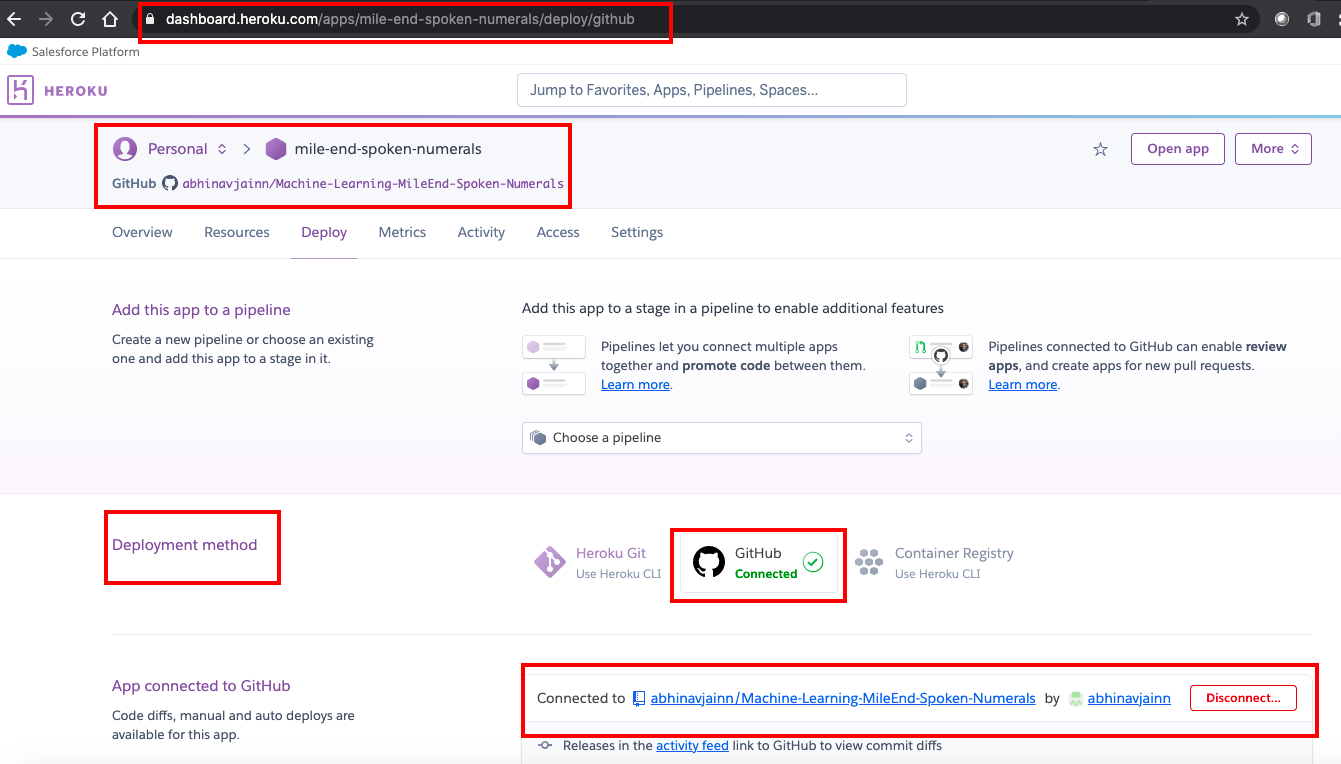


###2.1.2-Database

Screenshot of the database:

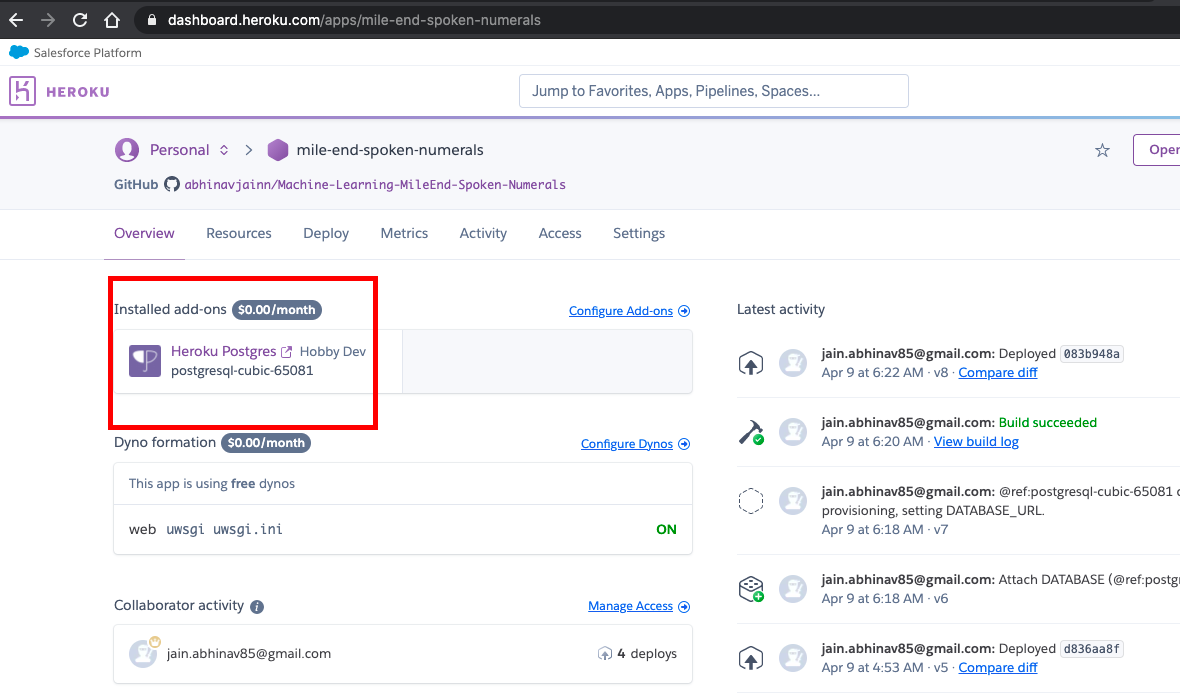


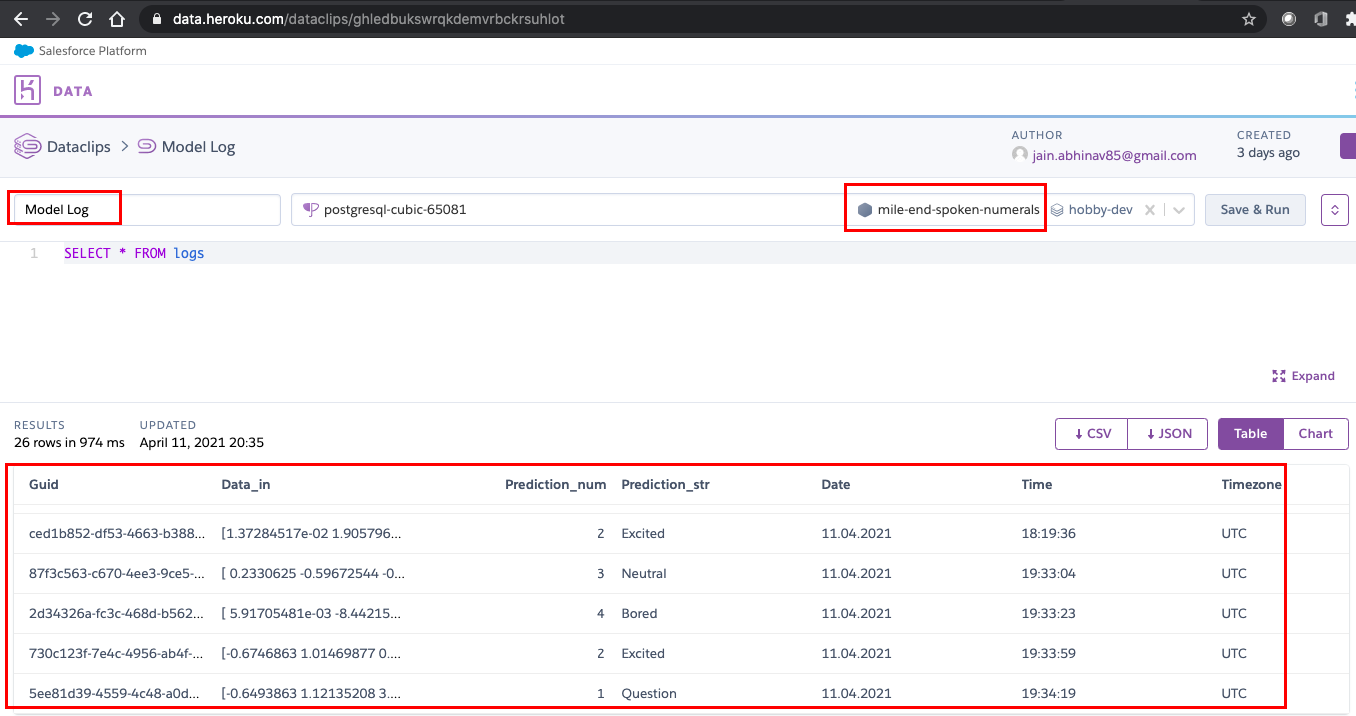

###2.1.3-Testing

####2.1.3.1-Using Linux shell script

Linux commands can be executed in the Colab notebook. Following command sends a GET request to the app's home endpoint.

In [ ]:
!curl --request GET https://mile-end-spoken-numerals.herokuapp.com/

You are at home page of "Mile End Spoken Numerals". Get a prediction via /predict-intonation endpoint.

App's home endpoint returns a welcome message.

Following command sends a GET request with input data in JSON format. Input data contains the features of the predictors of a record which was not seen by the model during training. The label is Excited.

In [ ]:
!curl -X GET \
  -H "Content-type: application/json" \
  -H "Accept: application/json" \
  -d '{"[0.777290321358166,0.844773324150843,0.524541343742578,1.71641619664159,-0.727669274064259,0.429327152295591,-0.274592525751703,0.119300753264375,-1.62488536466083,1.1989884657789,-0.441818225018342,0.191341092511253,0.331284193907661,-0.17180068074585,0.932666747262183,-0.657260310123978,0.0311846198609928,-0.655933052445209,-0.349371139008086,-0.555854917033178,-0.646769930743583,-0.197809795402086,-0.384987494441499,-0.515173293375295,0.0580578059913388,-0.68490503417094,0.277285043840829,-0.323849889344474,-0.166104092619205,-0.323260341550595,-1.14028384382999,0.797287861840624,0.243319734231631,-0.348316908891695,-0.481128969966569,-0.963141579752228,0.307834174061026,1.54488138281846,1.56427718989706,-1.63535229265094,-1.29550163060873,-1.04373142647843,0.0601614765353314,-0.0454740716217243,0.696119400643598,0.552519815839894,0.798101389478125,-0.492713100125631,-1.34927561393399,-0.0288671908825667,0.651937191086389,1.06113832383443,0.800983185682644,-0.82164741470001,-1.02129345376495,-0.190670638718149,-0.343169926692638,-0.133930363719446,-0.0675657406772101,-1.00953206141998,-1.14904798927652,0.129490444558012,0.747661300472293,0.996035056799905,0.745424701945987,-1.06424323343835,-0.945614428599212,-0.250707267253007,-0.809440964270084,-0.980253008945965]"}' \
  "https://mile-end-spoken-numerals.herokuapp.com/predict-intonation"

Prediction for intonation is: Excited

The model correctly predicts as Excited.

For the following request, expected label is question.

In [ ]:
!curl -X GET \
  -H "Content-type: application/json" \
  -H "Accept: application/json" \
  -d '{"[-0.587001267716284,-0.577420642816266,-0.0620748159459495,0.0732792880136386,1.31653979336326,-0.121582673853273,0.541293863086824,-0.914529031902813,0.35977221415778,-0.270386675580186,-0.45182513508561,0.605720679679315,-2.27075742031148,-1.62837286106,-2.14844883946036,-1.34969795596579,-1.90733534263105,-1.56059563783546,-1.9985544163599,-1.96303808011903,-1.64329393638985,-2.01371207525341,-1.77162903892334,-2.25371867425948,-1.9423933988587,-2.20144668612655,-1.76268297662489,-2.37210877110347,-1.9388834134824,-1.91502507277941,2.2817561668866,-0.547451197885775,-1.45567342784775,0.307703078330167,-0.0532501515455368,1.10299566990788,-1.41521722589645,-0.638000873819853,-1.66445634455884,-0.367971514749318,-1.17025623038352,-1.14533419419508,1.25922132793556,-0.921281490421603,-0.989035103636121,-0.565663949882614,-0.652944197837977,-0.238752455782442,-0.645914893542917,-0.585648104869462,-1.41666465665618,-0.725588660004915,1.05697982268279,2.19923962770883,-0.312593869444281,-0.798242197503533,-0.407060700343694,-0.166172558203173,-0.105373870700564,0.0688409702584166,-0.351647348856691,-0.341301652847236,-1.10038868381851,-0.15390885539161,1.08001143406797,2.63462048904134,0.0383954815492077,-0.251251362827133,-0.220041514733111,0.0114517807430742]"}' \
  "https://mile-end-spoken-numerals.herokuapp.com/predict-intonation"

Prediction for intonation is: Bored

The model incorrectly predicts this data as Bored.

Let us try one more. This time, expected label is Bored.

In [ ]:
!curl -X GET \
  -H "Content-type: application/json" \
  -H "Accept: application/json" \
  -d '{"[-0.207178996636462,-0.675138765833442,-0.84421014459091,-0.169032196384976,0.179580975230768,1.29280668578931,1.19727595669154,0.796786231663653,0.218011118046962,0.018834082275776,-0.421350588725276,-0.867973088309278,-0.439309901788659,1.03240302811063,-0.229055722302835,0.813569918660753,-1.66538947998986,0.468163534394534,-0.455873063832944,-0.662980924652499,-0.34532367109453,-0.39388915523151,-0.213087025492809,-0.505276937180701,0.236211861521639,-1.01924823497159,0.485110031021731,-0.240989666341377,0.218726095168049,-0.245535920486397,-0.10518798406151,0.255932115395122,0.122955923492692,-0.153334420196365,1.35969725598075,1.09976394259036,-1.43507894338542,-1.19183341598636,-1.54778180899617,-1.39123902886298,-2.23276715909536,-1.48704474012018,1.32206071724056,-0.787730585056585,-0.822663399617016,-1.30792234508813,-1.16895013894299,0.203419059669098,-0.305841460657091,-1.1808752902277,-1.43962365397387,-1.35395290023649,0.0036198892233311,1.36867803546982,1.80362732882833,0.689943524272691,-1.11391359925075,-1.36643032518895,-1.23252087359389,0.529433117406983,-0.516497582076927,-1.18537725342359,-1.24626895451864,-1.28569042281111,-0.261691279429285,1.21900783965887,1.23129672332297,0.0582772454521034,0.0115494846371483,-0.58451590429351]"}' \
  "https://mile-end-spoken-numerals.herokuapp.com/predict-intonation"

Prediction for intonation is: Bored

The model correctly predicts this data as Bored.

For the following request, expected label is neutral.

In [ ]:
!curl -X GET \
  -H "Content-type: application/json" \
  -H "Accept: application/json" \
  -d '{"[-0.504700550465927,-0.663651372831613,-0.452358708540644,0.326606325520918,-0.956091296738209,-1.1719262201564,-1.3901693854504,-0.410660239865946,-0.1447559519658,-0.310796224960836,-0.45182513508561,0.195185933717794,-0.587504104712808,0.376152002319885,0.286508108692951,-1.24999948006117,-0.483752021443373,-0.486982361765409,-1.08648057840038,-1.07328636433007,-1.07097447891809,-0.604034616530797,-0.902204653987194,-1.03247719478031,-0.809925715870441,-0.345219072970586,-0.971288587957675,-0.462851179848691,-0.663772985784736,-0.851415611694648,0.0679661214258504,0.2514547684982,0.0638771636256622,0.430268423303879,-0.925459449333314,-1.54709951358511,-0.0946612507711207,-0.391457271591034,1.93216661139796,-0.369173522879913,1.00837388706539,1.71035847426899,0.00419422264767598,-0.14444590218431,0.564927496456072,-0.370777580930604,-0.825089027726016,-0.539517384288771,0.232015011185868,-0.710466218668084,-0.8896733747362,1.52264346078612,0.405900960530588,0.279485368682113,-0.950802437693019,-0.430998306389554,0.543932834311674,-0.649292174379088,-0.728339507341844,-0.641433184680264,0.27623148232094,-0.434585825023422,-0.504865865717563,1.27755037864864,-0.137713145655951,-0.0384946543969618,-0.459332535906027,-0.670269082471895,0.126590051052148,0.607822073736938]"}' \
  "https://mile-end-spoken-numerals.herokuapp.com/predict-intonation"

Prediction for intonation is: Neutral

The model correctly predicts this data as Neutral.

####2.1.3.2-Using Postman tool

Following video shows a live demonstration of the app using Postman Rest API testing tool.

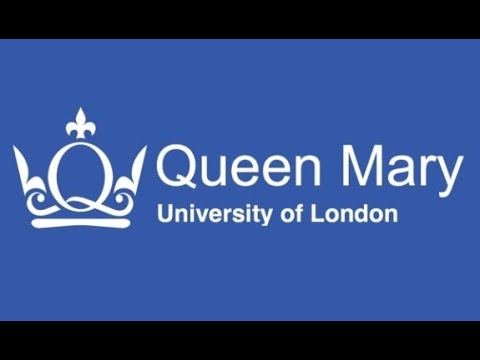

In [ ]:
from IPython.display import  YouTubeVideo
YouTubeVideo('2QlFTNEkWX8')